In [1]:
from mlp import MultiLayerPerceptron
from TwoDimProblem import TwoDimProblem
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Speed Test compared to non-compiled version

In [20]:
from mlp import MultiLayerPerceptron
p = TwoDimProblem(value_range=5)
X, y = p.createData(soln_rank=1, noise_frac=0, samples=100)
X_batch, y_batch = X[:5], y[:5].reshape(-1,1)
m = MultiLayerPerceptron(
    epochs=50, 
    lr=0.1,
    activation='sigmoid',
    input_layer=2, 
    hidden_layers=[2],
    output_layer=1)
print(f"X_batch: {X_batch.shape}")
print(f"y_batch: {y_batch.shape}")

X_batch: (5, 2)
y_batch: (5, 1)


In [81]:
from compiled_functions import batch_backprop_compiled, batch_backprop
from numba.typed import List
print("Trying non-compiled backprop: ")
print(batch_backprop(X_batch, y_batch, m._weights, m._biases, m.activation, m.dActivation, m._structure))
%timeit batch_backprop(X_batch, y_batch, m._weights, m._biases, m.activation, m.dActivation, m._structure)
print("Trying compiled backprop: ")
weights = List(m._weights)
biases = List(m._biases)
print(batch_backprop_compiled(X_batch[:,:, np.newaxis], y_batch[:,:,np.newaxis], weights, biases, m.activation, m.dActivation, m._structure))
%timeit batch_backprop_compiled(X_batch[:,:, np.newaxis], y_batch[:,:,np.newaxis], weights, biases, m.activation, m.dActivation, m._structure)

Trying non-compiled backprop: 
([array([[0.],
       [0.]]), array([[-0.075]])], [array([[0., 0.],
       [0., 0.]]), array([[-0.0375],
       [-0.0375]])])
471 µs ± 59.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Trying compiled backprop: 
([array([[0.],
       [0.]]), array([[-0.075]])], [array([[0., 0.],
       [0., 0.]]), array([[-0.0375],
       [-0.0375]])])
45.6 µs ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Test MLP from other file

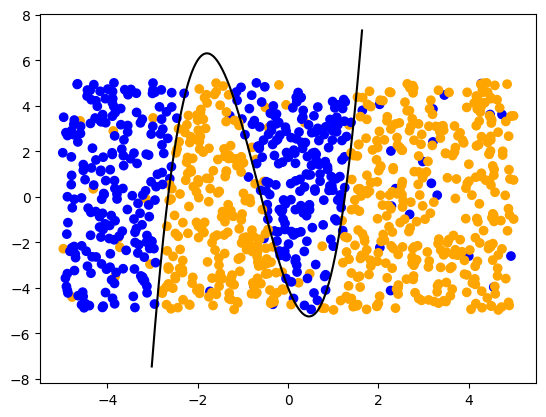

In [95]:
p = TwoDimProblem(value_range=5)
X, y = p.createData(soln_rank=3, noise_frac=0.05, samples=1000)
p.plotData(True)

100%|██████████| 100/100 [00:08<00:00, 11.56it/s]


Accuracy = 0.933


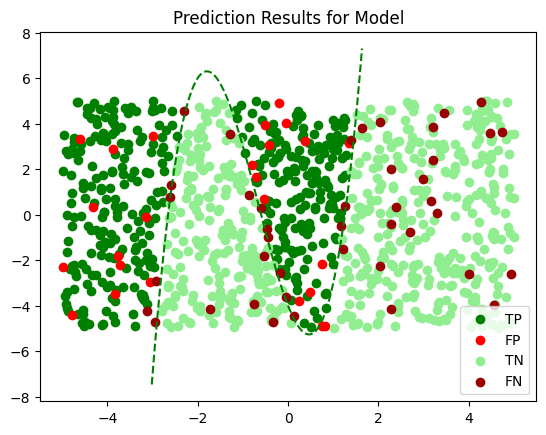

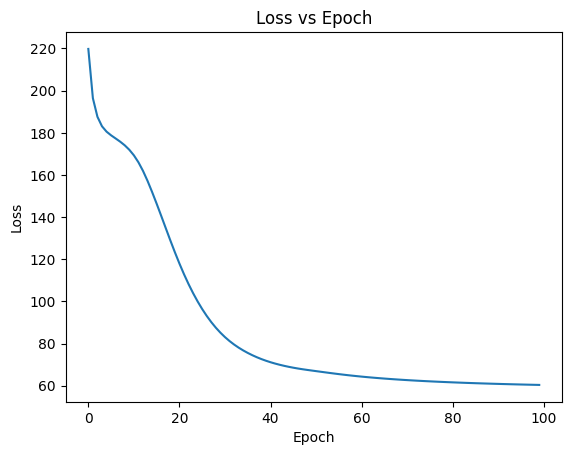

In [96]:
from mlp import MultiLayerPerceptron
m = MultiLayerPerceptron(
    epochs=100, 
    lr=0.1,
    activation='sigmoid',
    input_layer=2, 
    hidden_layers=[4,3],
    output_layer=1)
    
m.fit(X,y, batch_size=2)
pred = m.predict(X)
p.plotPred(pred, show_correct=True)
m.plot_loss()